In [1]:
import torch
import numpy as np
import torchvision as tv
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

from model.networks_tf import Generator, Discriminator
#from model.networks import Generator, Discriminator

## Load generator model


In [2]:
use_cuda_if_available = True
device = torch.device('cuda' if torch.cuda.is_available() 
                             and use_cuda_if_available else 'cpu')
generator = Generator(cnum_in=5, cnum=48, return_flow=True).to(device)

generator_state_dict = torch.load('pretrained/states_tf_celebahq.pth')['G']
generator.load_state_dict(generator_state_dict)

<All keys matched successfully>

## Load image and mask


In [12]:
image = r"D:\frank\paper\RAFT\demo-frames\lulabtop1\000020.png"
mask  = r"D:\frank\paper\RAFT\demo-frames\final_mask\000020.png"

image = Image.open(image)
mask = Image.open(mask)

## Plot raw image and mask


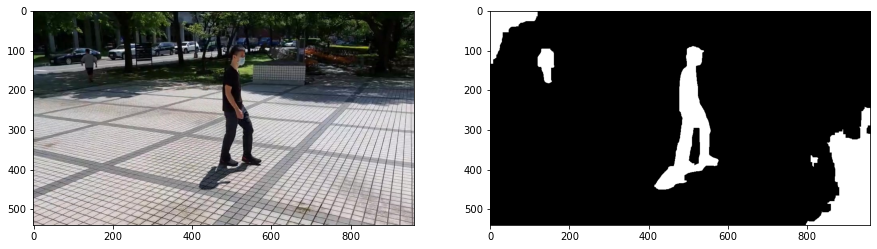

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)  # plot raw image
plt.subplot(1, 2, 2)
plt.imshow(mask)   # plot masked image


## Preprocess image and mask


In [14]:
# preprocessing
image_org = T.ToTensor()(image)
mask = T.ToTensor()(mask)

_, h, w = image_org.shape
grid = 8

image = image_org[:3, :h//grid*grid, :w//grid*grid].unsqueeze(0)
mask = mask[0:1, :h//grid*grid, :w//grid*grid].unsqueeze(0)

print(f"Shape of image: {image.shape}")

image = (image*2 - 1.).to(device)  # map image values to [-1, 1] range
mask = (mask > 0.).to(dtype=torch.float32, device=device)  # 1.: masked 0.: unmasked

image_masked = image * (1.-mask)  # mask image

ones_x = torch.ones_like(image_masked)[:, 0:1, :, :]
x = torch.cat([image_masked, ones_x, ones_x*mask], dim=1)  # concatenate channels


Shape of image: torch.Size([1, 3, 536, 960])


## Inpaint masked image


In [15]:
with torch.no_grad():
    x_stage1, x_stage2, offset_flow = generator(x, mask)

image_inpainted = image_masked * (1.-mask) + x_stage2 * mask

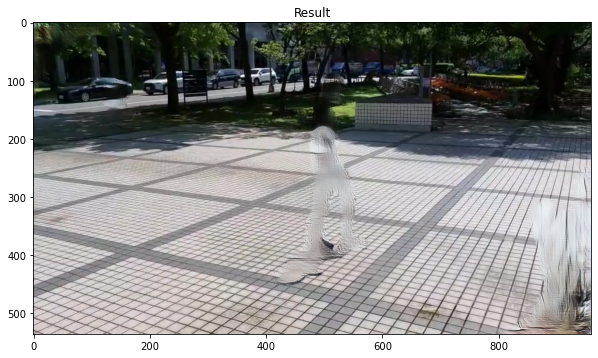

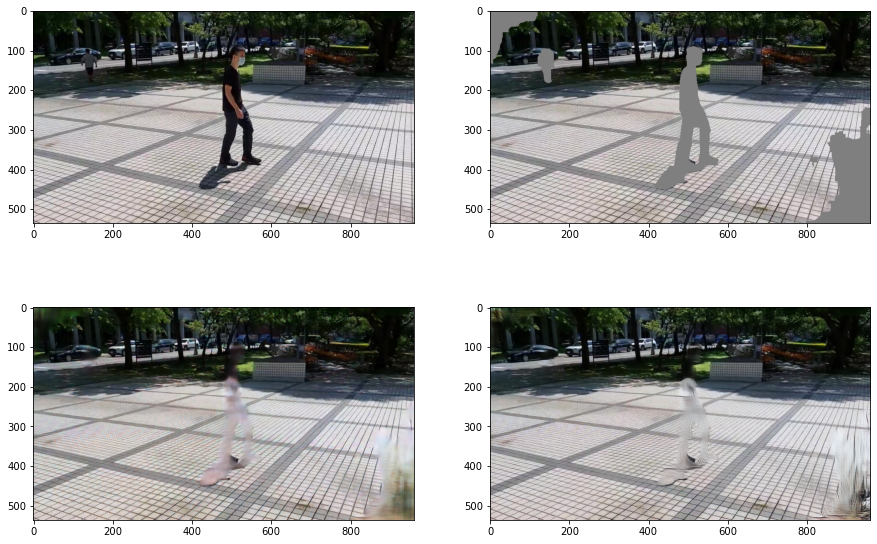

In [16]:
def pt_to_rgb(pt): return pt[0].cpu().permute(1, 2, 0)*0.5 + 0.5


plt.figure(figsize=(10, 8))
plt.title('Result')
plt.imshow(pt_to_rgb(image_inpainted))
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(pt_to_rgb(image))
plt.subplot(2, 2, 2)
plt.imshow(pt_to_rgb(image_masked))
plt.subplot(2, 2, 3)
plt.imshow(pt_to_rgb(x_stage1))
plt.subplot(2, 2, 4)
plt.imshow(pt_to_rgb(x_stage2))

### Plot attention flow map


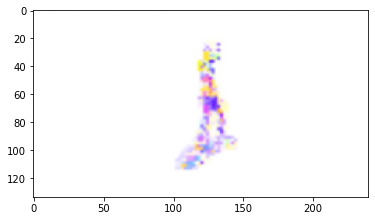

In [8]:
plt.imshow(offset_flow[0].cpu().permute(1, 2, 0))

## Test Contextual Attention


Size of imageA: torch.Size([1, 3, 128, 126])
Size of imageB: torch.Size([1, 3, 332, 500])


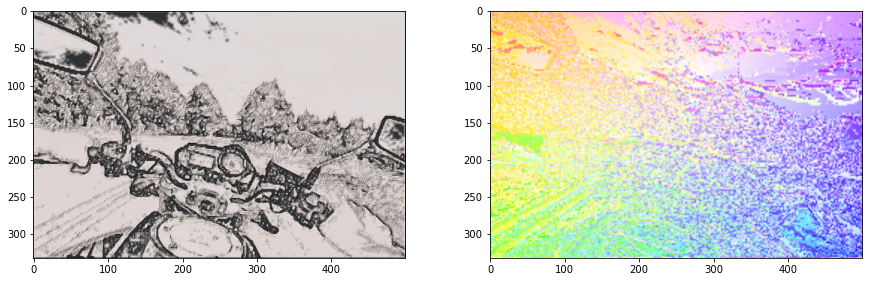

In [9]:

from model.networks import ContextualAttention
#from model.networks_tf import ContextualAttention


contextual_attention = ContextualAttention(ksize=3, stride=1, rate=2, 
                                           fuse_k=3, softmax_scale=10, 
                                           fuse=False,
                                           return_flow=True)

imageB = 'examples/style_transfer/bike.jpg'
imageA = 'examples/style_transfer/bnw_butterfly.png'

def test_contextual_attention(imageA, imageB):
    """Test contextual attention layer with 3-channel image input
    (instead of n-channel feature).
    
    """
    rate = 2
    stride = 1
    grid = rate*stride
    
    b = Image.open(imageA)
    b = b.resize((b.width//2, b.height//2), resample=Image.BICUBIC)
    b = T.ToTensor()(b)

    _, h, w = b.shape
    b = b[:, :h//grid*grid, :w//grid*grid].unsqueeze(0)

    print(f"Size of imageA: {b.shape}")

    f = T.ToTensor()(Image.open(imageB)) 
    _, h, w = f.shape
    f = f[:, :h//grid*grid, :w//grid*grid].unsqueeze(0)
 
    print(f"Size of imageB: {f.shape}")   

    yt, flow = contextual_attention(f*255., b*255.)

    return yt, flow


yt, flow = test_contextual_attention(imageA, imageB)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(yt[0].permute(1, 2, 0)/255.)
plt.subplot(2, 2, 2)
plt.imshow(flow[0].permute(1, 2, 0))
